In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip3 install xgboost
from xgboost import XGBRegressor, plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression


In [2]:
data = pd.read_csv('Data/data_with_new_features.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value,date,timeOfDay,year,month,day,phaseOfDay
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0,2014-02-26,13:00:00.000,2014,2,26,1
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0,2014-02-26,15:00:00.000,2014,2,26,1
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0,2014-02-26,18:00:00.000,2014,2,26,2
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0,2014-02-26,21:00:00.000,2014,2,26,2
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0,2014-02-27,09:00:00.000,2014,2,27,0


In [3]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


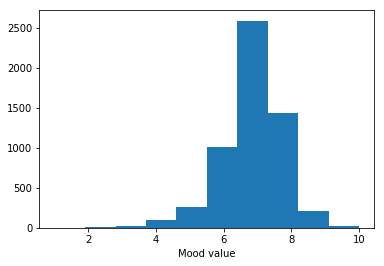

In [4]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


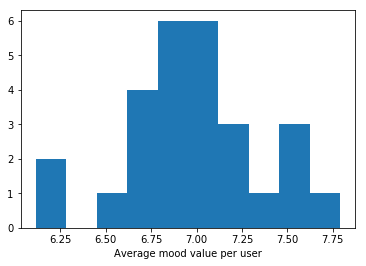

In [5]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.xlabel("Average mood value per user")
plt.show()



In [6]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))






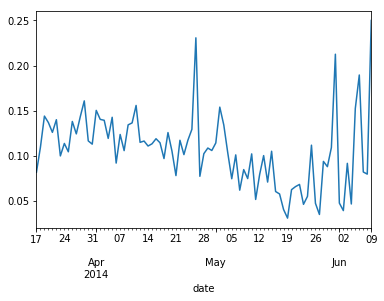

In [7]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='activity']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [8]:
variables = data['variable'].unique()
#generating new df
original = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence','activity']

#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        original[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        original[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()

#target at day is the same as mood at day
original['target'] = original['mood']

In [9]:
### ONLY NEED TO RUN CODE BELOW HERE TO TEST NEW FEATURES
date_data = original.copy()
new_sum_variables = []
new_temporal_variables = []

# variable deleted due to noise
del date_data["appCat.weather"]

In [10]:
# Add temporal variables
features = date_data.copy()
features['dayofweek'] = data.index.get_level_values('date').dayofweek
features['phaseOfDay'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['phaseOfDay'].mean()#.

# Discarded temporal variables (after experimentation)
#features['day'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['day'].mean()#.
#features['month'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['month'].mean()#.
#features.loc[features.dayofweek >= 5, 'weekend'] = 1
#features.loc[features.dayofweek < 5, 'weekend'] = 0

# Add special variables (combining correlated apps)
features['leisureApps'] = features['appCat.entertainment'] + features['appCat.game']
features['sadApps'] = features['appCat.social']+features['appCat.travel']
features['businessApps'] = features['appCat.finance']+features['appCat.utilities']
features['otherApps'] = features['appCat.unknown'] + features['appCat.other']

new_temporal_variables = ['dayofweek','day']
new_sum_variables = ['leisureApps','sadApps','businessApps','otherApps']

date_data = features.copy()

In [11]:
#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)

#filling missing values were NaN means 0
sum_variables = sum_variables + new_sum_variables
values0 = {key: 0 for key in sum_variables}

date_data.fillna(value=values0, inplace=True)
date_data[mean_variables] = date_data[mean_variables].fillna( method =  'ffill')

In [12]:
date_data.head()

mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000               -0.25            0.750000   
        2014-02-27  6.333333                0.00            0.333333   
        2014-03-21  6.200000                0.20            0.200000   
        2014-03-22  6.400000                0.60            0.500000   
        2014-03-23  6.800000                0.20            0.800000   

                    activity        screen  call  sms  appCat.builtin  \
id      date                                                            
AS14.01 2014-02-26       NaN      0.000000   1.0  2.0           0.000   
        2014-02-27       NaN      0.000000   0.0  0.0           0.000   
        2014-03-21  0.134050  17978.907000   6.0  0.0        3139.218   
        2014-03-22  0.236880   6142.161000   3.0  1.0         731.429   
        2014-03-23  0.142741   6773.832001   0.0  0.0        1286.246   

                    appCat.communication  appCat.entertainment    ...      \
id      date                                                      ...       
AS14.01 2014-02-26                 0.000                 0.000    ...       
        2014-02-27                 0.000                 0.000    ...       
        2014-03-21              6280.890              1007.456    ...       
        2014-03-22              4962.918                93.324    ...       
        2014-03-23              5237.319                94.346    ...       

                    appCat.travel  appCat.unknown  appCat.utilities    target  \
id      date                                                                    
AS14.01 2014-02-26          0.000             0.0             0.000  6.250000   
        2014-02-27          0.000             0.0             0.000  6.333333   
        2014-03-21        915.445             0.0           598.754  6.200000   
        2014-03-22         37.305             0.0           117.621  6.400000   
        2014-03-23          0.000             0.0            30.086  6.800000   

                    dayofweek  phaseOfDay  leisureApps   sadApps  \
id      date                                                       
AS14.01 2014-02-26          2    1.500000          0.0     0.000   
        2014-02-27          3    0.666667          0.0     0.000   
        2014-03-21          4    1.000000          0.0  5423.945   
        2014-03-22          5    1.200000          0.0   476.937   
        2014-03-23          6    1.200000          0.0     0.000   

                    businessApps  otherApps  
id      date                                 
AS14.01 2014-02-26         0.000        0.0  
        2014-02-27         0.000        0.0  
        2014-03-21       648.298        0.0  
        2014-03-22       138.697        0.0  
        2014-03-23        73.489        0.0  

[5 rows x 25 columns]

In [13]:
lagged_date_data = date_data.copy()
#rolling mean
lag = 10
rolling_variables  = list(lagged_date_data.columns)

not_lagged = ['target'] + new_temporal_variables
for variable in not_lagged:
    if variable in rolling_variables:
        rolling_variables.remove(variable)

#for lag in range(1,max_lag):
for variable in rolling_variables:
    if variable not in not_lagged:
        lagged_date_data["{}_lagged_by_{}".format(variable, lag)]=lagged_date_data[variable].rolling(window = lag).mean().shift(1)

In [14]:
#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets
lagged_date_data.dropna(axis = 0,subset = ["target"], inplace=True)
lagged_date_data.dropna(axis = 0, inplace=True)
final_features = lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = rolling_variables)

# Insert target column in the front
target = final_features["target"]
del final_features["target"]
final_features.insert(0,"target",target)

final_features.head(15)

,target,dayofweek,mood_lagged_by_10,circumplex.arousal_lagged_by_10,circumplex.valence_lagged_by_10,activity_lagged_by_10,screen_lagged_by_10,call_lagged_by_10,sms_lagged_by_10,appCat.builtin_lagged_by_10,...,appCat.other_lagged_by_10,appCat.social_lagged_by_10,appCat.travel_lagged_by_10,appCat.unknown_lagged_by_10,appCat.utilities_lagged_by_10,phaseOfDay_lagged_by_10,leisureApps_lagged_by_10,sadApps_lagged_by_10,businessApps_lagged_by_10,otherApps_lagged_by_10
date,,,,,,,,,,,,,,,,,,,,,
2014-03-31,7.40,0,6.765,0.140000,0.575000,0.116482,11905.288200,3.0,0.4,2188.3031,...,128.1672,1767.2822,260.5313,30.1700,230.1130,1.165,123.8439,1269.8081,203.7096,55.4522
2014-04-01,6.00,1,6.885,0.120000,0.615000,0.110127,11291.080900,3.0,0.4,2170.5218,...,131.0475,1451.4977,187.3249,33.0990,191.2681,1.185,304.8535,880.8172,164.0358,85.2366
2014-04-02,6.50,2,6.845,0.080000,0.565000,0.098284,12394.255400,2.8,0.3,2235.9306,...,133.3522,1911.5412,345.0565,33.0990,231.2696,1.185,431.3913,1498.5923,256.7123,85.2366
2014-04-03,6.40,3,6.815,0.093333,0.551667,0.094201,13852.723300,3.2,0.3,2468.7409,...,180.2240,2164.3365,345.0565,33.0990,262.3981,1.190,431.3913,1498.5923,308.2782,85.2366
2014-04-04,6.20,4,6.855,-0.106667,0.551667,0.091229,14488.171700,2.6,0.3,2614.1917,...,194.9584,2157.3980,304.9842,33.0990,262.8021,1.190,431.3913,1451.5815,312.8950,85.2366
2014-04-05,6.80,5,6.800,-0.136667,0.541667,0.094061,13578.577300,2.8,0.3,2706.6978,...,194.7566,2174.0706,320.8083,9.5767,253.3820,1.185,431.3913,1676.0253,286.3003,43.8324
2014-04-06,6.50,6,6.820,-0.156667,0.541667,0.095830,12270.240300,2.8,0.3,4105.8671,...,193.1201,1751.1855,339.6028,9.5767,261.9411,1.185,431.3913,1731.1406,277.7307,43.8324
2014-04-07,6.50,0,6.770,-0.251667,0.511667,0.086320,11272.757500,3.0,0.2,4437.8006,...,199.1789,1689.7934,334.8714,9.5767,248.6631,1.195,461.5533,1632.8711,255.6059,43.8324
2014-04-08,6.60,1,6.780,-0.258333,0.476667,0.081817,11765.046700,2.6,0.2,3524.2788,...,193.6186,1786.0611,227.5952,9.5767,239.0725,1.200,337.7094,1621.8626,241.7115,43.8324


In [15]:
final_features.corr(method="pearson")["target"]

target                               1.000000
dayofweek                            0.094065
mood_lagged_by_10                    0.438862
circumplex.arousal_lagged_by_10      0.013576
circumplex.valence_lagged_by_10      0.211524
activity_lagged_by_10                0.096197
screen_lagged_by_10                  0.071528
call_lagged_by_10                   -0.052920
sms_lagged_by_10                    -0.115001
appCat.builtin_lagged_by_10          0.012011
appCat.communication_lagged_by_10    0.102668
appCat.entertainment_lagged_by_10    0.115799
appCat.finance_lagged_by_10          0.048819
appCat.game_lagged_by_10             0.131708
appCat.office_lagged_by_10           0.095140
appCat.other_lagged_by_10            0.176500
appCat.social_lagged_by_10          -0.046034
appCat.travel_lagged_by_10          -0.069834
appCat.unknown_lagged_by_10          0.059804
appCat.utilities_lagged_by_10        0.067087
phaseOfDay_lagged_by_10             -0.099919
leisureApps_lagged_by_10          

In [16]:
feature_data = np.array(final_features)#lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y = feature_data[:,1:], feature_data[:,0]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

###
model = XGBRegressor()
model.fit(X_train, y_train)

[17:54:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

[17:54:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

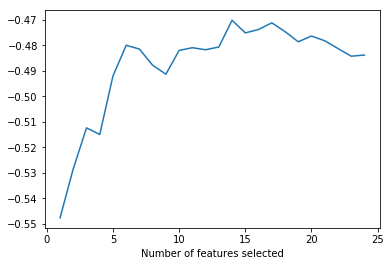

In [17]:
#Feature Cross Validation
from sklearn.model_selection import StratifiedKFold , cross_validate
from sklearn.feature_selection import RFECV



rfecv = RFECV(estimator=model, step=0.01,      #cross_validate(model, X = X_train, y = y_train),
              scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [18]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "max_depth": np.arange(3, 10),
    "min_child_weight": np.arange(1,10),
    "learning_rate" : np.linspace(0,0.1, 100),
    "gamma": np.arange(0,10),
    "subsample" : np.linspace(0.5, 1, 100),
    "colsample_bytree" :np.linspace(0.5, 1, 100),
    "reg_lambda" : np.linspace(0.5, 1, 100),
    "reg_alpha" : np.linspace(0, 1, 100)}

n_iter_search = 30
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, scoring = "neg_mean_squared_error")
random_search.fit(X_train, y_train)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

[17:54:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:55:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[17:55:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model with rank: 1
Mean validation score: -0.449 (std: 0.073)
Parameters

In [19]:
def dict_to_arguments(dictionary):
    t = ""
    for key, value in dictionary.items():
        t+="{} = {:} ,".format(key, value)
    return t
dict_to_arguments({'subsample': 0.9494949494949496, 'reg_lambda': 0.803030303030303, 'reg_alpha': 0.5656565656565657, 'min_child_weight': 8, 'max_depth': 6, 'learning_rate': 0.050505050505050504, 'gamma': 1, 'colsample_bytree': 0.803030303030303})

'subsample = 0.9494949494949496 ,reg_lambda = 0.803030303030303 ,reg_alpha = 0.5656565656565657 ,min_child_weight = 8 ,max_depth = 6 ,learning_rate = 0.050505050505050504 ,gamma = 1 ,colsample_bytree = 0.803030303030303 ,'

In [20]:
model = XGBRegressor(subsample = 0.9494949494949496 ,reg_lambda = 0.803030303030303 ,reg_alpha = 0.5656565656565657 ,min_child_weight = 8 ,max_depth = 6 ,learning_rate = 0.050505050505050504 ,gamma = 1 ,colsample_bytree = 0.803030303030303 , objective='reg:squarederror')#(max_depth=4, reg_alpha=0.4,  base_score=1, colsample_bynode=0.0,objective='reg:squarederror'  )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#print(y_test, predictions)
accuracy = mean_squared_error(y_test, y_pred)
print("MSE: {:.5}" .format(accuracy))
print(X_test.shape)
print(X_train.shape)

MSE: 0.36357
(415, 24)
(840, 24)


In [70]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.803030303030303, gamma=1,
       importance_type='gain', learning_rate=0.050505050505050504,
       max_delta_step=0, max_depth=6, min_child_weight=8, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0,
       reg_alpha=0.5656565656565657, reg_lambda=0.803030303030303,
       scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9494949494949496, verbosity=1)

In [36]:
np.sqrt(np.sum((y_test- y_pred)**2)/len(y_test))

0.6029679063812367

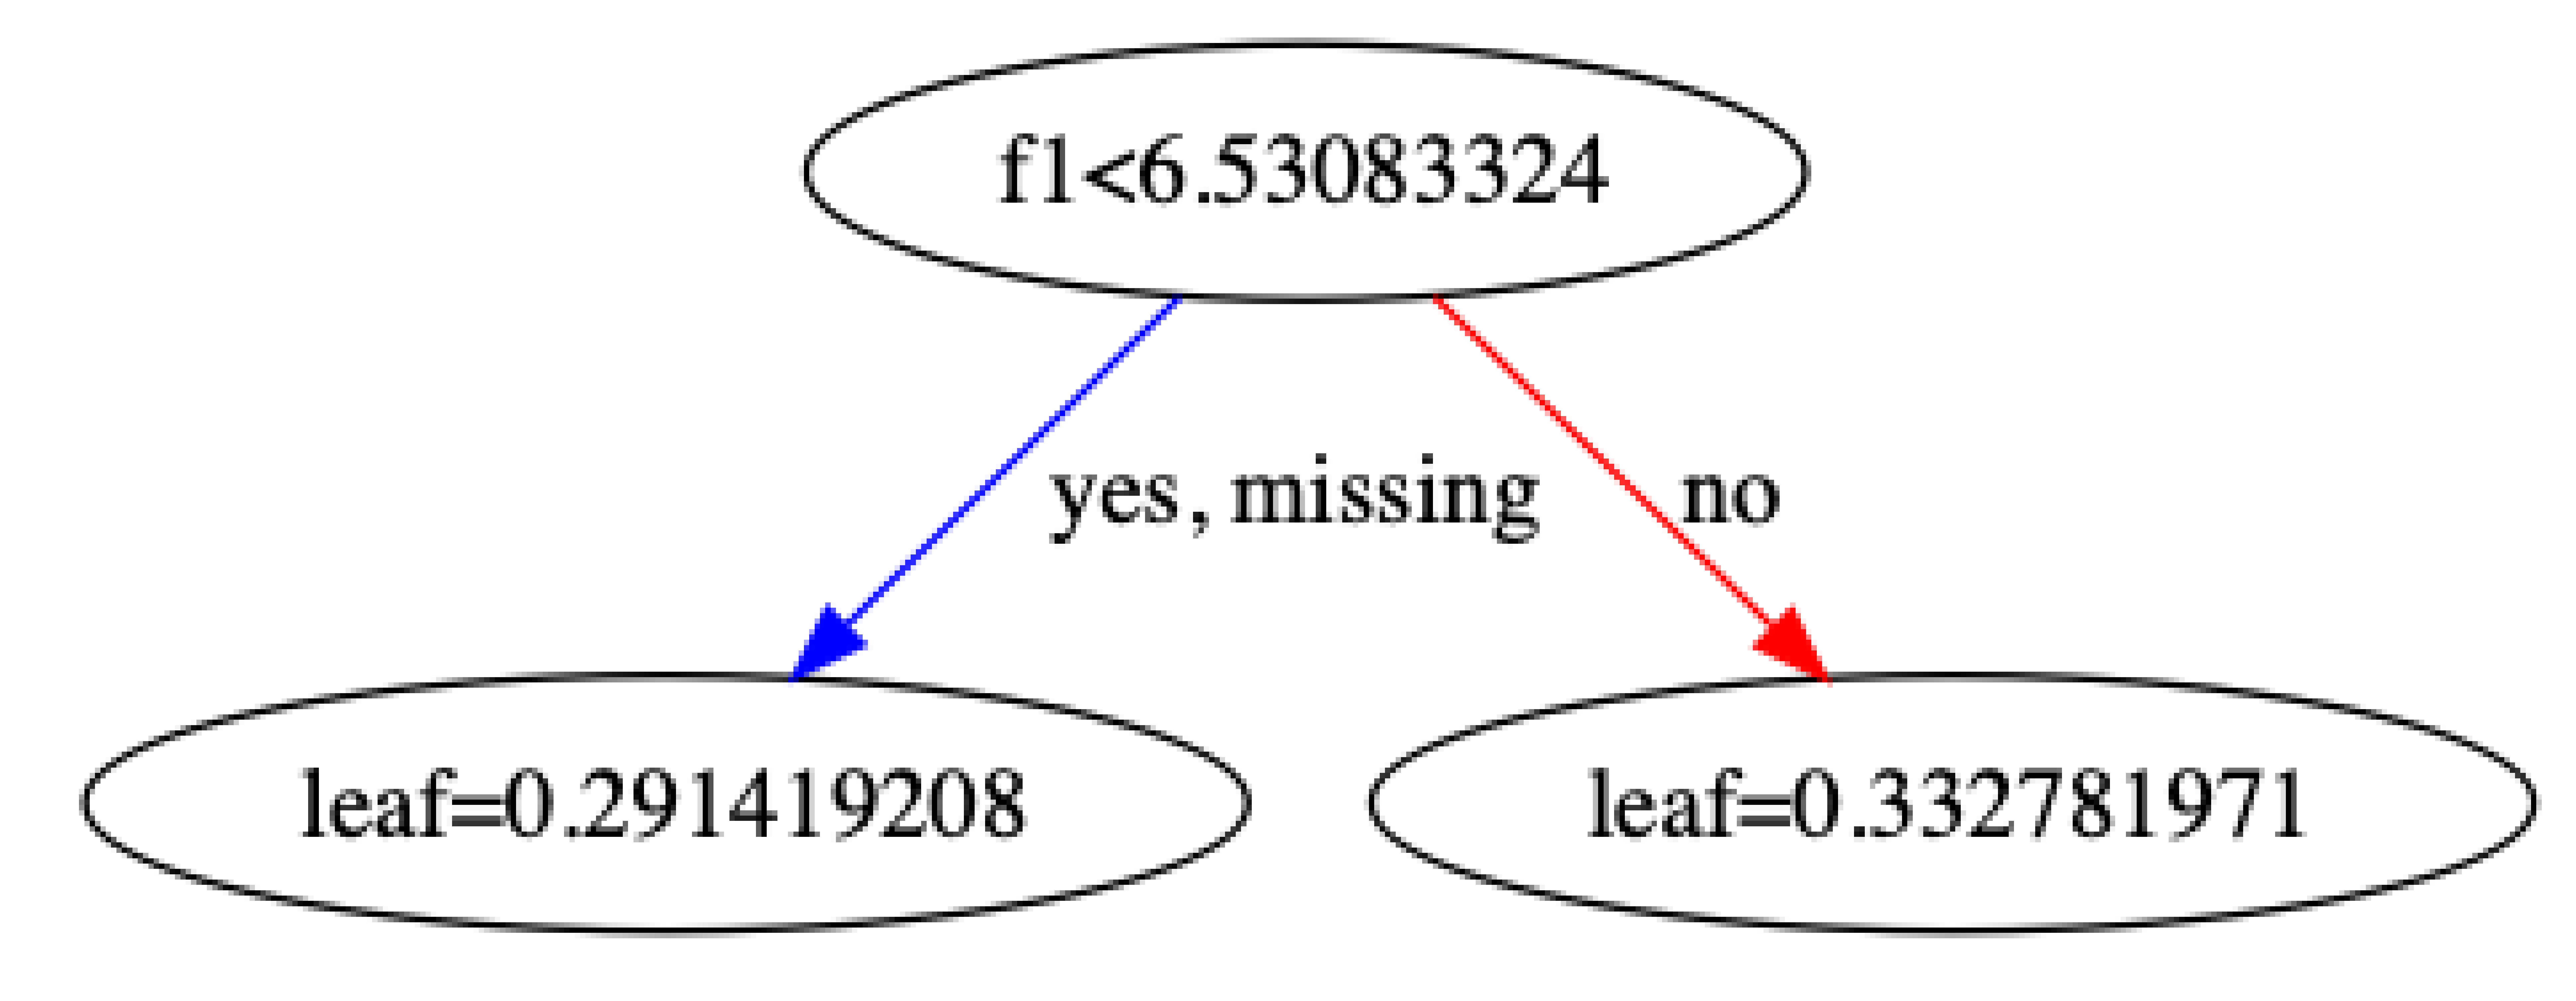

In [56]:
fig = plt.figure( figsize=(50, 10), dpi=500, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
plot_tree(model, num_trees=10, ax = ax1)
plt.show()

In [69]:
x_t = X_test.copy()
x_t = x_t[:1, :]
x_t[0,0] = 6.7
model.predict(x_t)

array([7.4975095], dtype=float32)

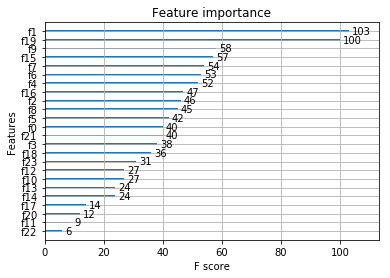

In [52]:
plot_importance(model)
plt.show()

In [46]:
#baseline  MSE: 0.9917
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y_test[1:], y_test[:-1])
print("MSE: {:.4}" .format(accuracy))

MSE: 0.9917


In [42]:
(np.sum((y[1:]- x)**2)/len(x))

0.47199797268459237